# Deciding on community detection algorithms

In [37]:
import networkx as nx
from networkx.algorithms.community import quality

import pandas as pd
import community
import numpy as np
import matplotlib.pyplot as plt
import cdlib as cd
from cdlib import algorithms
from cdlib import evaluation

Import graph with references as nodes and edge weights based on Gmür (2003) CoCit-value

In [3]:
Ggmuer = nx.read_gexf("Ggmuer.gexf")

# Louvain: 
- guarantees that modularity cannot be increased by merging any two communities of the network and creates local optima (modularity: -1 to 1, a value close to 1 suggests a clear community structure with well-defined communities, a value close to 0 indicates a weak or no community structure, and a value close to -1 indicates a network divided into communities that are poorly separated or even overlapping)
- does not ! guarantee that modularity cannot be increased by moving a single node from one community to another
- might be slow for large networks


Modification of resolution parameter to find out how it affects the number of clusters:

In [21]:
coms = algorithms.louvain(Ggmuer, weight='weight', resolution=0.8, randomize=False) 
# resolution: higher values lead to smaller communities
# randomize: randomize the node evaluation order and get different partitions at each call

len(coms.communities)

evaluation.size(Ggmuer, coms)
evaluation.size(Ggmuer, coms, summary = False) 
# summary = False gives list of floats 
# # Size is the number of nodes in the community

[117,
 66,
 59,
 32,
 25,
 21,
 18,
 18,
 14,
 11,
 11,
 8,
 8,
 8,
 8,
 7,
 5,
 5,
 4,
 4,
 3,
 2,
 2,
 2,
 2]

Test with different resolutions and compare the results

In [19]:
clusters = [] # takes a few seconds to run

for resolution in np.linspace(0,1,20):
    coms = algorithms.louvain(Ggmuer, weight='weight', resolution = resolution, randomize=False)
    clusters.append(len(coms.communities))

clusters = np.array(clusters)
min_clusters_idx = np.argmin(clusters) # argmin returns the indices of the minimum values along an axis
min_resolution = np.linspace(0, 1, 20)[min_clusters_idx]

print("Minimum clusters:", clusters[min_clusters_idx])
print("Resolution with minimal clusters:", min_resolution)

Minimum clusters: 7
Resolution with minimal clusters: 0.8421052631578947


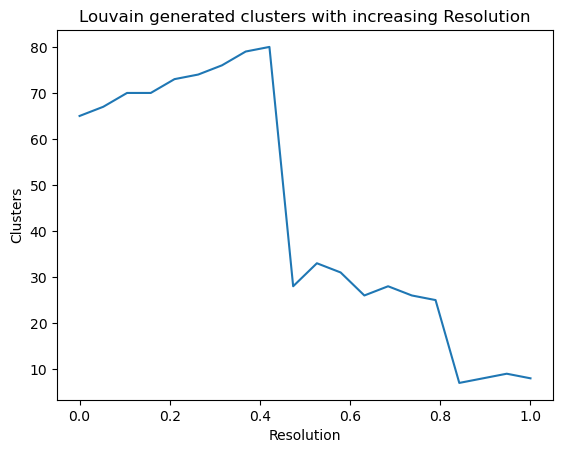

In [20]:
x = np.linspace(0, 1, 20)
y = clusters

plt.plot(x, y)
plt.xlabel('Resolution')
plt.ylabel('Clusters')
plt.title('Louvain generated clusters with increasing Resolution')
plt.show()

Due to mentioned restrictions of the Louvain algorithm, we will consider Leiden, which incorporates several improvements.

## Leiden algorithm:
Evaluate the numbers of clusters and provide reproducibility:

The Leiden algorithm tends to generate around eight clusters consistently when applied to our network. Although the algorithm has a random element, we try mitigate this by checking for specific seed values for reproducibility.

NOTE ON SEEDS: <br>
With cdlib leiden, it is by default not possible to not randomize, because the cdlib leiden algorithm (--> Go to definition) is basically using the leidenalg find_partition, which does have a randomizing argument, but cdlib sets seeds = None. <br>
So, if you want to set a seed, you have to change the cdlib code. <br>
Alternatively, you can use the leidenalg find_partition directly, which allows you to set a seed. This again needs a transformation of the partitions into a format that can be used by cdlib for the metrics we want to use.
But in the cdlib leiden definition, this is already being done in the context of referring to leidenalg and might as well be used by us manually.

In [76]:
import inspect

inspect.getfullargspec(algorithms.leiden)

FullArgSpec(args=['g_original', 'initial_membership', 'weights'], varargs=None, varkw=None, defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={'return': <class 'cdlib.classes.node_clustering.NodeClustering'>, 'g_original': <class 'object'>, 'initial_membership': <class 'list'>, 'weights': <class 'list'>})

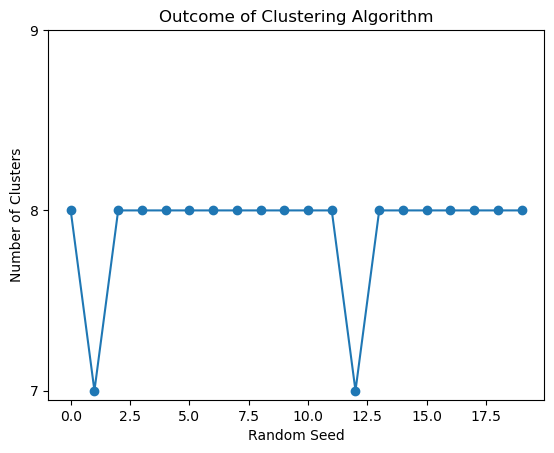

In [89]:
num_seeds = 20 # results for 1000 seeds include even 10 clusters
seeds = range(num_seeds)

# list to store number of clusters for all seeds
num_communities = []
all_communities = []

for seed in seeds:
    randseed = np.random.RandomState(seed=seed)  # Set the random seed for reproducibility # problematic since we are not using it again within the function
    coms = algorithms.leiden(Ggmuer, weights='weight')
    num_communities.append(len(coms.communities))
    all_communities.append(coms)#.communities)

plt.plot(seeds, num_communities, marker='o')
plt.yticks(range(7,10))
plt.xlabel('Random Seed')
plt.ylabel('Number of Clusters')
plt.title('Outcome of Clustering Algorithm')
plt.show()

Investigate the number of nodes in each cluster for each of the seeds:

In [90]:
for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that will merge elements from two or more data sources into one
    print("Seed:", seed)
    for idx, community in enumerate(communities.communities):
        print("Community", idx+1, "Size:", len(community))

Seed: 0
Community 1 Size: 116
Community 2 Size: 113
Community 3 Size: 63
Community 4 Size: 60
Community 5 Size: 51
Community 6 Size: 41
Community 7 Size: 8
Community 8 Size: 8
Seed: 1
Community 1 Size: 113
Community 2 Size: 109
Community 3 Size: 67
Community 4 Size: 56
Community 5 Size: 55
Community 6 Size: 52
Community 7 Size: 8
Seed: 2
Community 1 Size: 112
Community 2 Size: 102
Community 3 Size: 67
Community 4 Size: 58
Community 5 Size: 53
Community 6 Size: 46
Community 7 Size: 14
Community 8 Size: 8
Seed: 3
Community 1 Size: 111
Community 2 Size: 106
Community 3 Size: 70
Community 4 Size: 62
Community 5 Size: 53
Community 6 Size: 36
Community 7 Size: 14
Community 8 Size: 8
Seed: 4
Community 1 Size: 110
Community 2 Size: 97
Community 3 Size: 67
Community 4 Size: 59
Community 5 Size: 50
Community 6 Size: 45
Community 7 Size: 24
Community 8 Size: 8
Seed: 5
Community 1 Size: 93
Community 2 Size: 92
Community 3 Size: 75
Community 4 Size: 54
Community 5 Size: 50
Community 6 Size: 46
Comm

In [91]:
# better overview
table_nodes = {} # dictionary for cluster sizes

for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that merges elements from several data sources into one
    seed_name = f"Seed {seed}" # remember f-strings
    for clusnr, community in enumerate(communities.communities):
        community_name = f"Community {clusnr+1}"
        table_nodes.setdefault(community_name, {})[seed_name] = len(community)

df = pd.DataFrame(table_nodes) # dict into df

print(df)

         Community 1  Community 2  Community 3  Community 4  Community 5  \
Seed 0           116          113           63           60           51   
Seed 1           113          109           67           56           55   
Seed 2           112          102           67           58           53   
Seed 3           111          106           70           62           53   
Seed 4           110           97           67           59           50   
Seed 5            93           92           75           54           50   
Seed 6           107          104           74           62           53   
Seed 7           115          115           67           63           50   
Seed 8           111          106           70           62           53   
Seed 9           110           92           67           55           51   
Seed 10          117           98           72           63           54   
Seed 11          116          116           67           58           52   
Seed 12     

Compare partitions of the Leiden algorithm with different seeds by using cd lib evaluation metrics:

 - embeddedness of a node n w.r.t. a community C is the ratio of its degree within the community and its overall degree emb(n,C)=kCn/kn --> high values indicate that a node is well embedded in a community

In [93]:
embeddedness_values = []

for c in all_communities: # all_communities contains the clusterings for all seeds
    embeddedness_value = evaluation.avg_embeddedness(Ggmuer, c)
    embeddedness_values.append(embeddedness_value)

df_embseeds = pd.DataFrame({"Embeddedness": embeddedness_values})

print(df_embseeds)

# results refer to FitnessResult(min=, max=, score=, std=)


                                         Embeddedness
0   (0.05102126158284866, 0.440205752232158, 0.253...
1   (0.12402918498609952, 0.440205752232158, 0.285...
2   (0.09405612339263547, 0.4165424056067694, 0.25...
3   (0.09405612339263547, 0.4253472519504003, 0.25...
4   (0.12402918498609952, 0.3957911815723665, 0.25...
5   (0.12402918498609952, 0.37870574206075863, 0.2...
6   (0.09405612339263547, 0.4265466260838753, 0.25...
7   (0.04259084878488765, 0.44517473524304957, 0.2...
8   (0.09405612339263547, 0.4253472519504003, 0.25...
9   (0.12402918498609952, 0.3957911815723665, 0.25...
10  (0.09405612339263547, 0.4146535048349016, 0.25...
11  (0.09405612339263547, 0.43339179175782616, 0.2...
12  (0.12402918498609952, 0.4381073024505179, 0.28...
13  (0.09405612339263547, 0.4304769295293566, 0.25...
14  (0.05102126158284866, 0.44642809593797694, 0.2...
15  (0.09405612339263547, 0.4253472519504003, 0.25...
16  (0.09405612339263547, 0.4381306190380532, 0.25...
17  (0.12402918498609952, 0.

Apparently, partitioning the network into seven clusters gives highest scores for embeddedness. But this might have to do with the concentration of similar nodes and stronger intra-cluster interactions when the network is partitioned into fewer clusters --> higher connectivity!

- hub dominance: a hub is a node that has a significantly higher number of connections or links compared to other nodes in the network; critical / influencial nodes; defined as the ratio of the degree of its most connected node w.r.t. the theoretically maximal degree within the community.

In [97]:
hub_values = []

for c in all_communities:
    hub_value = evaluation.hub_dominance(Ggmuer, c)
    hub_values.append(hub_value)

df_hub = pd.DataFrame({"Hub Dominance": hub_values})


print(df_hub)
# results refer to FitnessResult(min=, max=, score=, std=)

                                        Hub Dominance
0   (0.8225806451612904, 1.0, 0.9684475806451613, ...
1   (0.8333333333333334, 1.0, 0.9632034632034632, ...
2   (0.8333333333333334, 1.0, 0.9680555555555556, ...
3   (0.8260869565217391, 1.0, 0.9746894409937888, ...
4   (0.8333333333333334, 1.0, 0.9682971014492754, ...
5   (0.7972972972972973, 1.0, 0.9563694792353329, ...
6   (0.7945205479452054, 1.0, 0.9743150684931507, ...
7   (0.8333333333333334, 1.0, 0.9755952380952382, ...
8   (0.8260869565217391, 1.0, 0.9746894409937888, ...
9   (0.8333333333333334, 1.0, 0.9599358974358975, ...
10  (0.8169014084507042, 1.0, 0.9657490396927016, ...
11  (0.8333333333333334, 1.0, 0.9791666666666667, ...
12  (0.8260869565217391, 1.0, 0.958488612836439, 0...
13  (0.8260869565217391, 1.0, 0.9590301003344481, ...
14  (0.7945205479452054, 1.0, 0.9557965499746321, ...
15  (0.8333333333333334, 1.0, 0.9755952380952382, ...
16  (0.7808219178082192, 1.0, 0.9726027397260274, ...
17  (0.8285714285714286, 1.0

- modularity: high modularity score indicates that the network is divided into distinct and well-separated clusters; Z-modularity is another variant of the standard modularity proposed to avoid the resolution limit

In [100]:
zmod_values = []

for c in all_communities:
    zmod_value = evaluation.z_modularity(Ggmuer, c)
    zmod_values.append(zmod_value)

df_zmod = pd.DataFrame({"Modularity (Z-score-based)": zmod_values})


print(df_zmod)
# results refer to modularity score on third position

                 Modularity (Z-score-based)
0    (None, None, 0.2642399091931103, None)
1    (None, None, 0.2728444990162182, None)
2   (None, None, 0.27727621352609483, None)
3   (None, None, 0.27014793847719937, None)
4   (None, None, 0.25969305902092876, None)
5    (None, None, 0.2583578304810247, None)
6   (None, None, 0.27574471345128243, None)
7   (None, None, 0.26556752011299173, None)
8   (None, None, 0.27014793847719937, None)
9    (None, None, 0.2604448259895957, None)
10  (None, None, 0.26957920973145044, None)
11  (None, None, 0.26137104946975853, None)
12   (None, None, 0.2746024911479274, None)
13   (None, None, 0.2680198860544343, None)
14  (None, None, 0.26511309578670494, None)
15  (None, None, 0.26858527378497266, None)
16   (None, None, 0.2612708613104791, None)
17    (None, None, 0.261321014950685, None)
18   (None, None, 0.2681613732084168, None)
19   (None, None, 0.2616226676495762, None)
